# Decompose HSC observed QSO image

This notebook requires standard python libraries and the publicly available packages on github:
See https://github.com/dartoon/galight/blob/master/requirements.txt

This notebook has been tested with galight ==  0.1.0

For more information, please contact me: dingxuheng@126.com

This notebook is very similar to the 'galight_HST_QSO.ipynb', only that the noise_map, PSF are input to the fittings. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

#Data is available at: https://drive.google.com/file/d/1ZO9-HzV8K60ijYWK98jGoSoZHjIGW5Lc/view?usp=sharing
fitsFile = pyfits.open('../example_files/HSC/QSO/000017.88+002612.6_HSC-I.fits')

#Load the fov image data:
fov_image = fitsFile[1].data # check the back grounp

#Derive the header informaion, might be used to obtain the pixel scale and the exposure time.
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']

#Derive the fov noise level map:
err_data= fitsFile[3].data ** 0.5

#Calculate the zeropoint for HSC filters:
file_header0 = fitsFile[0].header
FLUXMAG0 = file_header0['FLUXMAG0']
zp =  2.5 * np.log10(FLUXMAG0)   # This is something Xuheng can't make sure.

#Load the PSF data:
PSF = pyfits.getdata('../example_files/HSC/QSO/000017.88+002612.6_HSC-I_psf.fits')

Estimating the background light ... ... ...
Plot target cut out zoom in:


/Users/Dartoon/Astro/my_packages/galight/galight/tools/measure_tools.py:599: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax1.imshow(image, origin='lower', cmap=my_cmap, norm=LogNorm(), vmin=vmin, vmax=vmax)


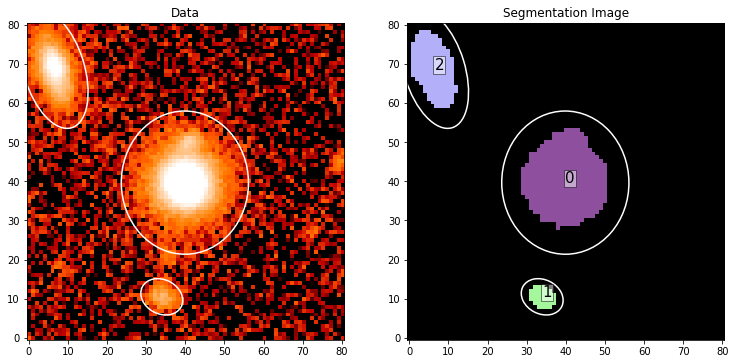

 id xcentroid ycentroid     source_sum         orientation      area
       pix       pix                               deg          pix2
--- --------- --------- ------------------ ------------------- -----
  1     33.97     10.48 14.877786632742579 -26.919403366519592  34.0
  0     39.88     39.65  946.9985284930266  -89.38756439152425 415.0
  2      6.44     68.57 135.45358705291244  -73.06461361938477 169.0
Input directly the a obj idx to mask, use space between each id:
2


/Users/Dartoon/Astro/my_packages/galight/galight/data_process.py:191: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im1 = ax1.imshow(target_stamp, origin='lower', norm=LogNorm(), vmax = target_stamp.max(), vmin = 1.e-4)
/Users/Dartoon/Astro/my_packages/galight/galight/data_process.py:201: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im3 = ax3.imshow(target_stamp * target_mask, origin='lower', norm=LogNorm(), vmax = target_stamp.max(), vmin = 1.e-4)


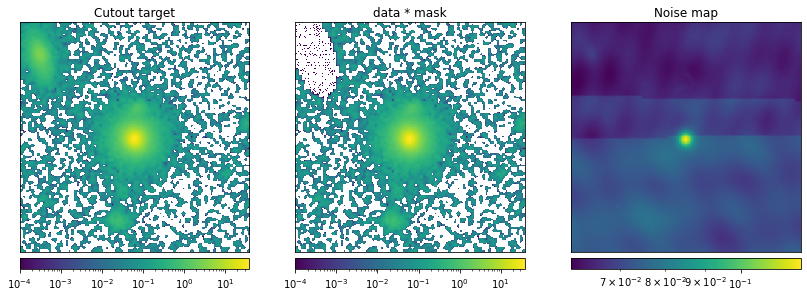

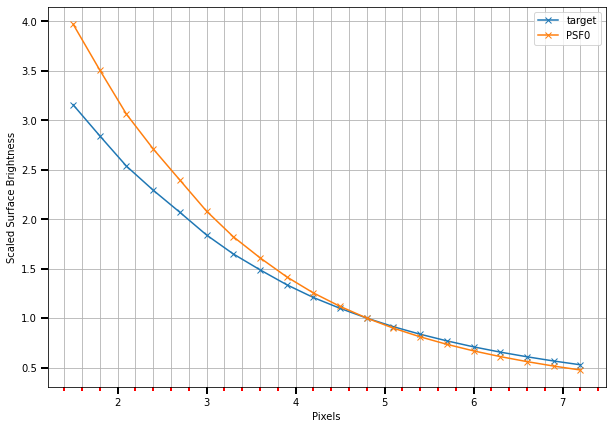

The PSF is not a box size, will cut it to a box size automatically.
The data_process is ready to go to pass to FittingSpecify!


In [2]:
from galight.data_process import DataProcess

#RA, DEC information of the QSO:
QSO_RA, QSO_DEC = 0.07452999800443649, 0.4368380010128021
data_process = DataProcess(fov_image = fov_image, fov_noise_map = err_data, target_pos = [QSO_RA, QSO_DEC],
                           pos_type = 'wcs', header = header,
                          rm_bkglight = True, if_plot=False, zp = zp)

#Generate the fitting materials
data_process.generate_target_materials(radius=None, create_mask = True, nsigma=2.8,
                                      exp_sz= 1.5, npixels = 15, if_plot=True)

#Manually input the PSF:
data_process.PSF_list = [PSF]

# Compare the 1D profile of all the components.
data_process.profiles_compare(norm_pix = 5, if_annuli=False, y_log = False,
                  prf_name_list = (['target'] + ['PSF{0}'.format(i) for i in range(len(data_process.PSF_list))]) )


#Check if all the materials is given, if so to pass to the next step.
data_process.checkout() #Check if all the materials is known.

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


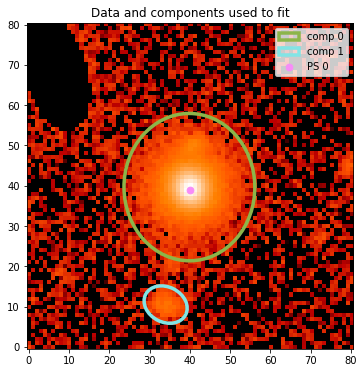

In [3]:
#Start to produce the class and params for lens fitting.
#For more details, see notebook galight_HST_QSO.ipynb
from galight.fitting_specify import FittingSpecify
fit_sepc = FittingSpecify(data_process)
fit_sepc.prepare_fitting_seq(point_source_num = 1)
#Using following line: want to fix Sersic_n as 4 for the source_id = 0, and if want to fix the QSO and host center:
# fit_sepc.prepare_fitting_seq(point_source_num = 1, fix_n_list= [[0,4]], fix_center_list = [[0,0]])

#Plot the initial settings for fittings. 
fit_sepc.plot_fitting_sets()

fit_sepc.build_fitting_seq()

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-1.5351766706803605 reduced X^2 of best position
-4761.350444115138 logL
6203.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.7974651490948351, 'n_sersic': 4.572248159988123, 'e1': -0.07039616463463585, 'e2': 0.0676074577961967, 'center_x': 0.07124697108704328, 'center_y': -0.05770143610973561}, {'amp': 1, 'R_sersic': 0.8671151066396864, 'n_sersic': 2.821266067127617, 'e1': -0.03047365487733127, 'e2': 0.3030710451796075, 'center_x': 1.0767606324075116, 'center_y': -5.074712455511988}] lens light result
[{'ra_image': array([0.00687747]), 'dec_image': array([-0.13336827]), 'point_amp': array([1.])}] point source result
{} special param result
22.85245180130005 time used for  PSO


100%|██████████| 130/130 [04:05<00:00,  1.88s/it]


Computing the MCMC...
Number of walkers =  140
Burn-in iterations:  100
Sampling iterations (in current run): 130
246.81217503547668 time taken for MCMC sampling
269.702 total time taken for the overall fitting (s)
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
Start transfering the Params to fluxs...
4200 MCMC samplers in total, finished translate: 1000
4200 MCMC samplers in total, finished translate: 2000
4200 MCMC samplers in total, finished translate: 3000
4200 MCMC samplers in total, finished translate: 4000


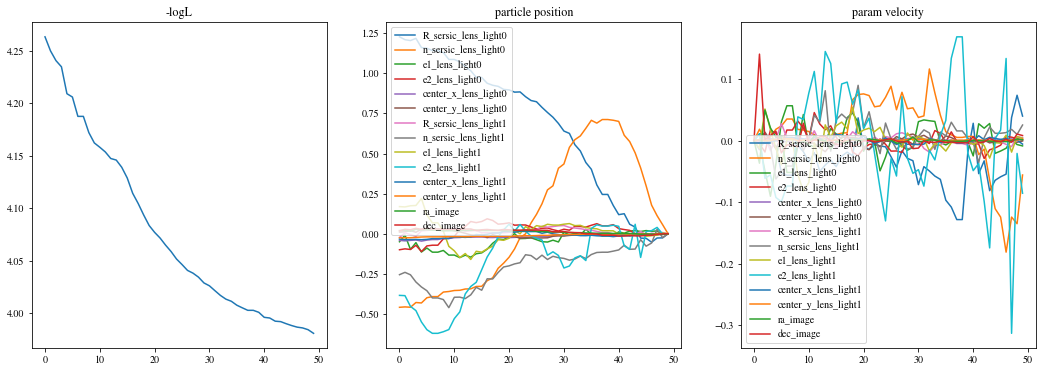

<Figure size 432x288 with 0 Axes>

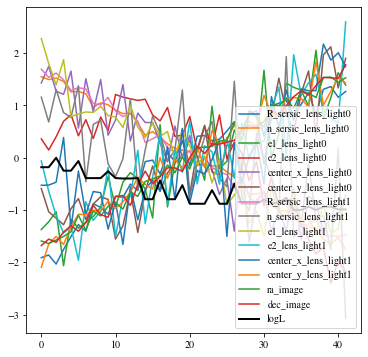

-1.4623279562056068 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.4623279562056068


/Users/Dartoon/.local/lib/python3.6/site-packages/lenstronomy/Plots/plot_util.py:199: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_bad(color='k', alpha=1.)
/Users/Dartoon/.local/lib/python3.6/site-packages/lenstronomy/Plots/plot_util.py:200: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_under('k')


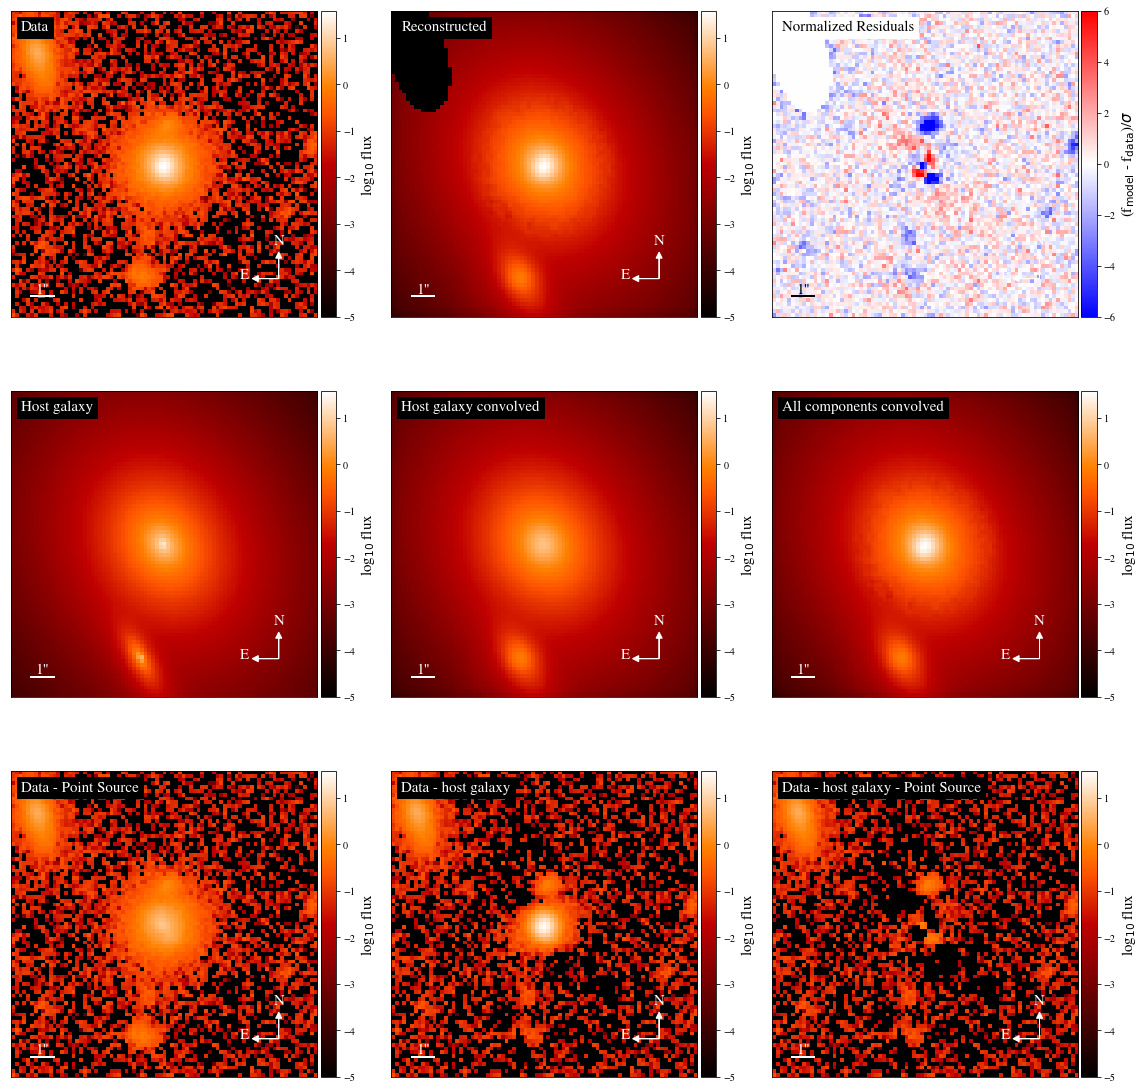

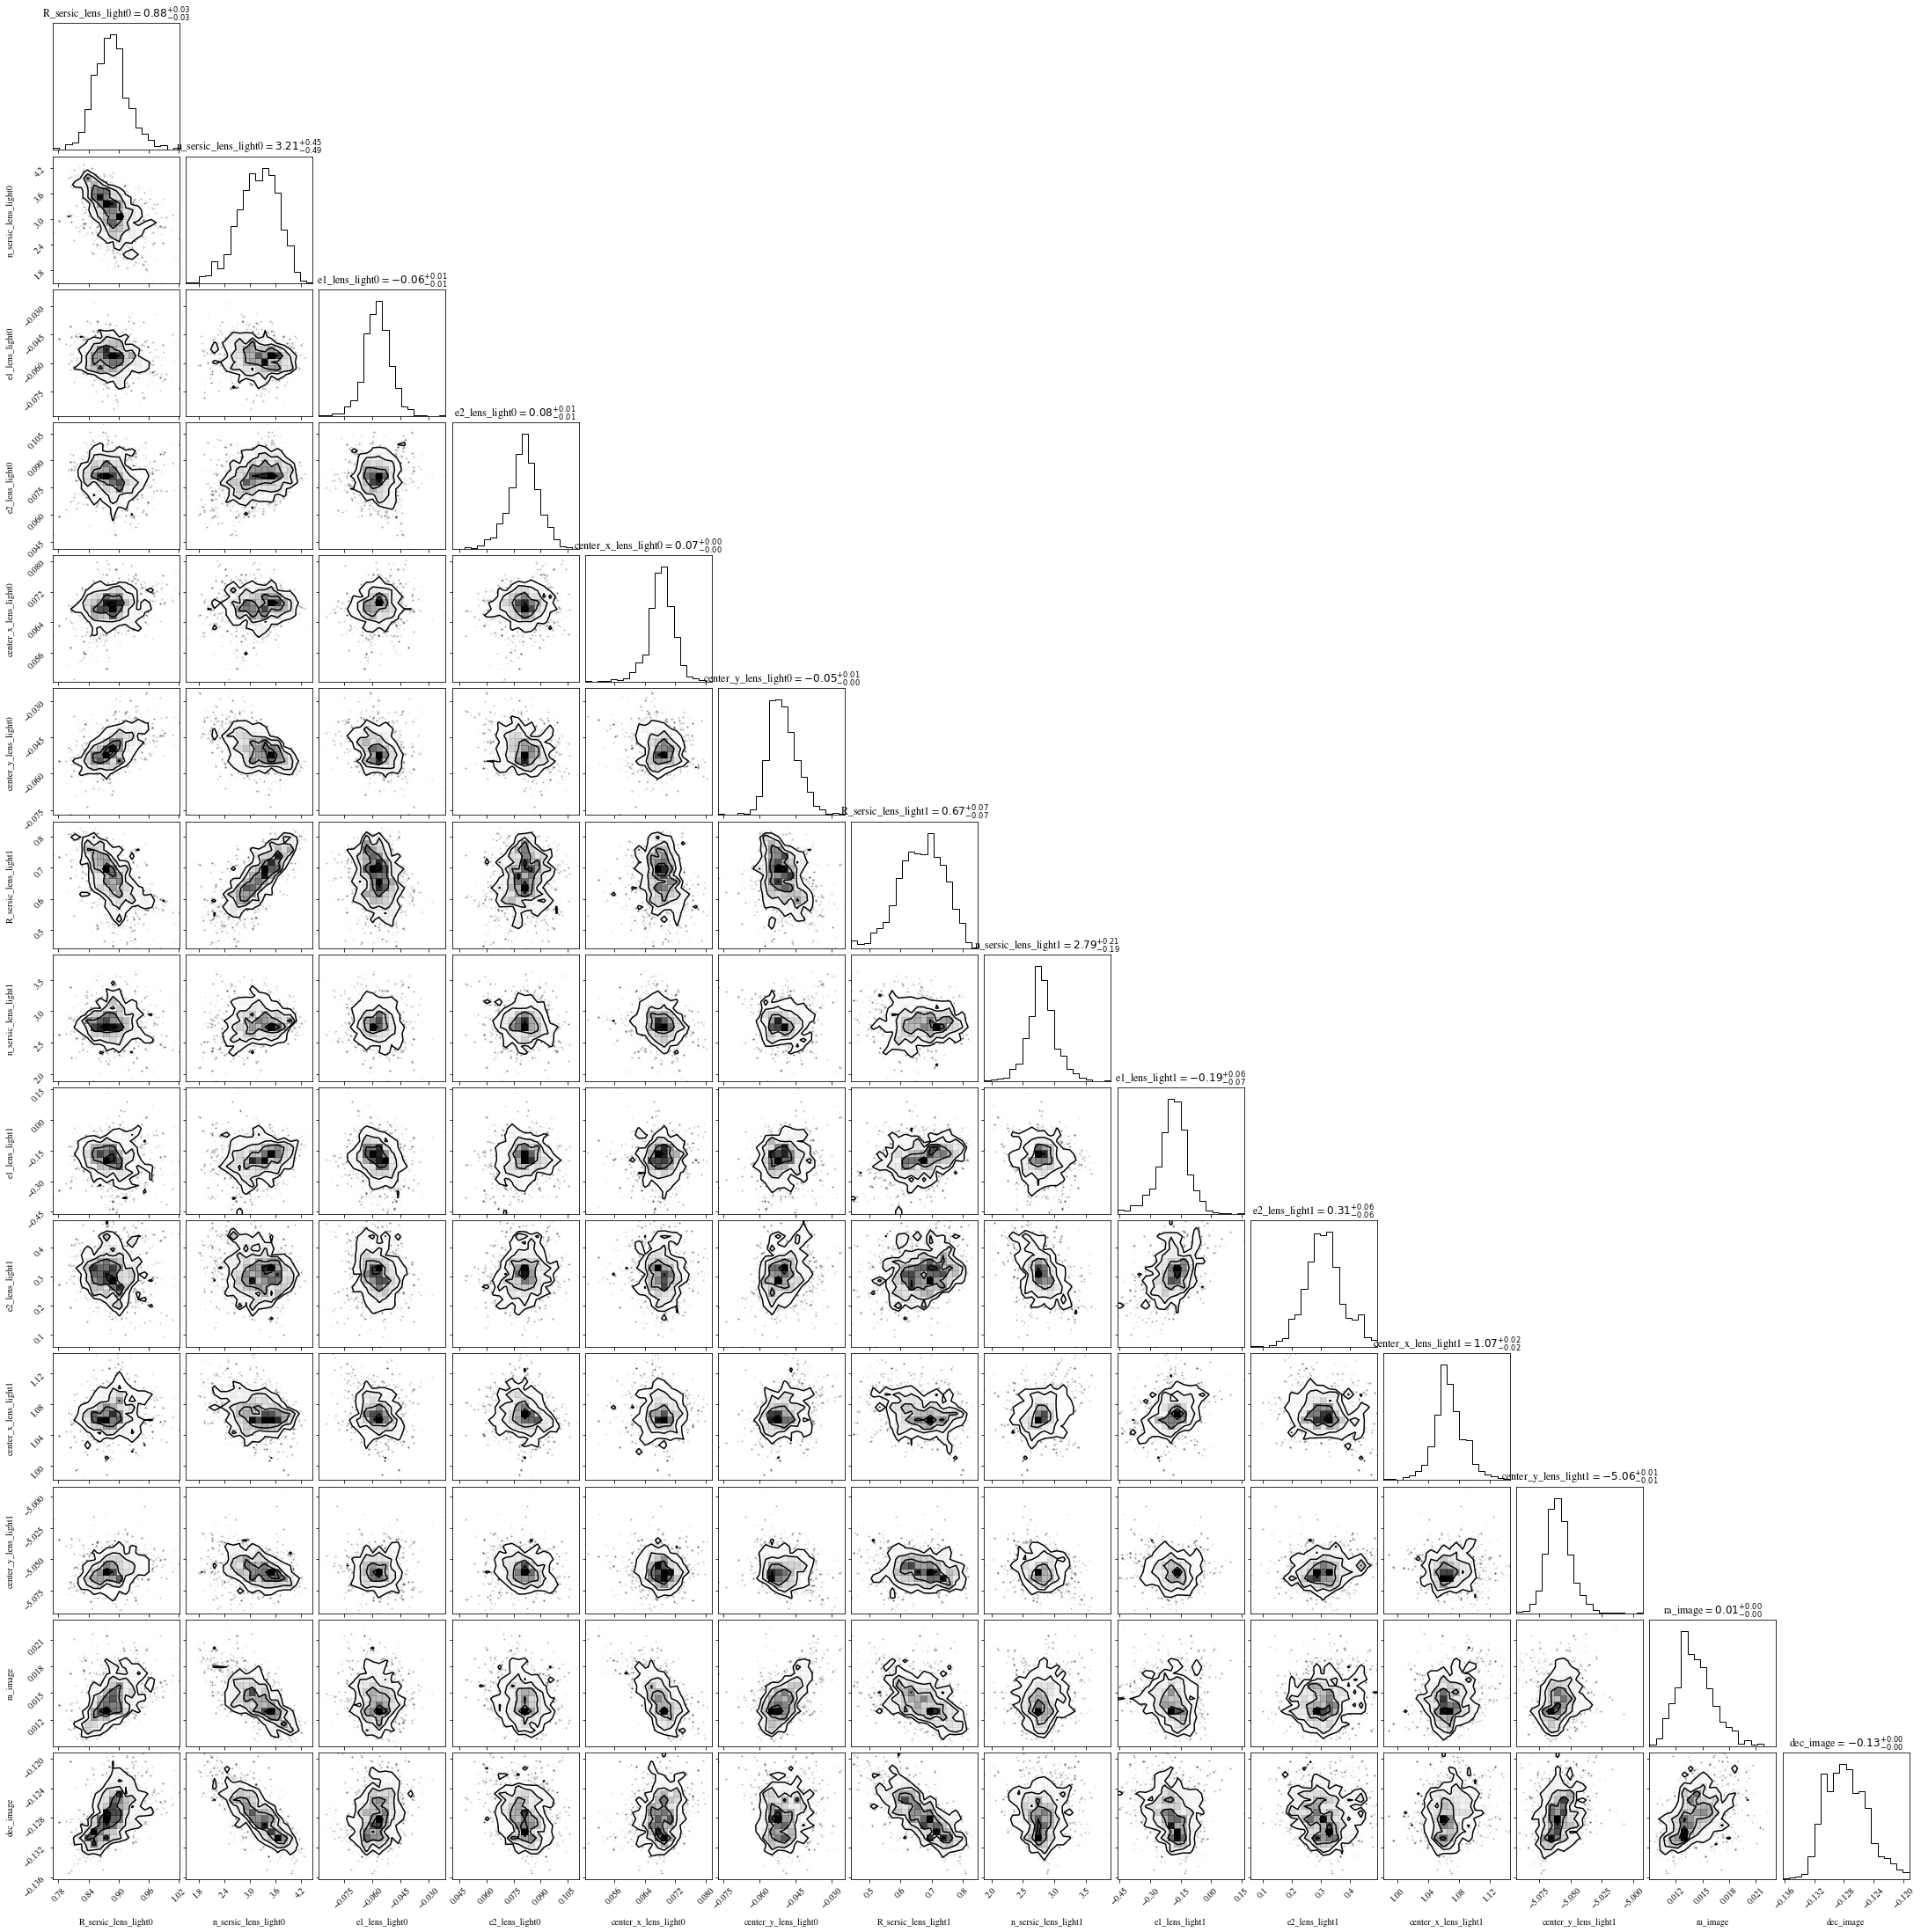

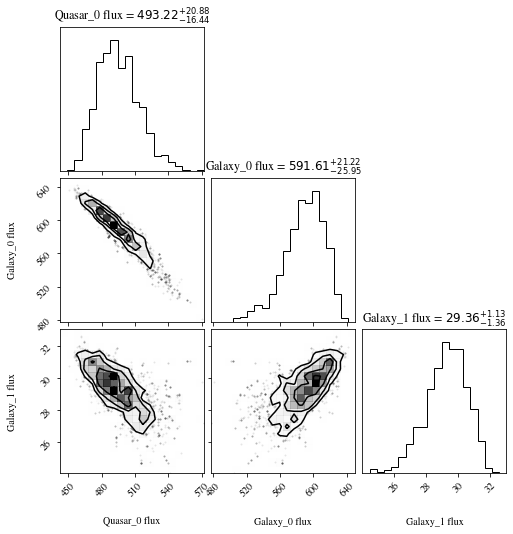

/Users/Dartoon/Astro/my_packages/galight/galight/tools/plot_tools.py:105: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  vmax = flux_list_2d[0].max(), vmin = 1.e-4)


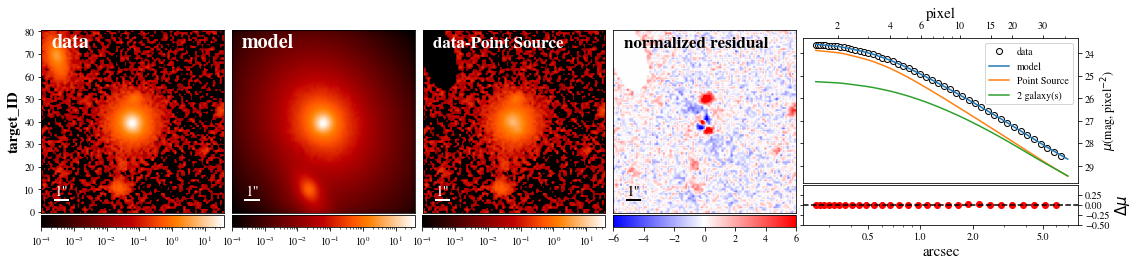

In [4]:
#Setting the fitting method and run.
from galight.fitting_process import FittingProcess

#Pass fit_sepc to FittingProcess,
# savename: The name of the saved files.    
fit_run = FittingProcess(fit_sepc, savename = 'HSC_result')

#Setting the fitting approach and Run: 
#     algorithm_list: The fitting approaches that would be used: e.g. ['PSO', 'PSO', 'MCMC']
#     setting_list: The detailed setting for the fitting: e.g. [[0.8, 50, 50], [0.8, 50, 50], [50, 100, 10, 0.1]]
#     -for PSO:
#         input template: {'sigma_scale': 0.8, 'n_particles': 50, 'n_iterations': 50}
#     -for MCMC:
#         input template: {'n_burn': 50, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}
#     if setting_list = [None, None, None], default values would be given 
fit_run.run(algorithm_list = ['PSO', 'MCMC'], setting_list = [None, None])

# Plot all the fitting results, including:
#         run_diag() : The convergence of the chains.
#         model_plot(): The model plot (by lenstronomy)
#         plot_params_corner(): The mcmc corner for all the chains (MCMC should be peformed) 
#         plot_flux_corner(): The flux corner for all the component (MCMC should be peformed)
#         plot_final_qso_fit() or plot_final_galaxy_fit(): Plot the overall plot (data, model, data-ps, resudal, 1D profile)
fit_run.plot_all()


#Save the fitting class as pickle format:
#     Note, if you use python3 (or 2), load with python3 (or 2)
fit_run.dump_result()

In [5]:
#Load the saved fitting class, the fitting_run_result would be the loaded as fit_run() in previous fittings.
import pickle
picklename = 'HSC_result.pkl'
fitting_run_result = pickle.load(open(picklename,'rb'))
#fitting_run_result.plot_final_qso_fit()
fitting_run_result.final_result_galaxy

[{'amp': 46.44844738903399,
  'R_sersic': 0.9159166273611542,
  'n_sersic': 2.0672767751531844,
  'e1': -0.05500061988562174,
  'e2': 0.09057410292216532,
  'center_x': 0.06362750560176952,
  'center_y': -0.041804972866436745,
  'phi_G': 1.0582627982352277,
  'q': 0.8083742945749127,
  'flux_sersic_model': 521.7742570934935,
  'flux_within_frame': 518.6982767377033,
  'magnitude': 20.212712987132626},
 {'amp': 13.617881479525408,
  'R_sersic': 0.5321870512032413,
  'n_sersic': 2.805270071174626,
  'e1': -0.25136964831783337,
  'e2': 0.36855733721867673,
  'center_x': 1.0765782316837031,
  'center_y': -5.057072501410896,
  'phi_G': 1.0846822053728717,
  'q': 0.3830130677233437,
  'flux_sersic_model': 28.249296980332392,
  'flux_within_frame': 26.91667815751521,
  'magnitude': 23.424946345785635}]